In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import bbknn

import seaborn as sns
import random

In [2]:
plt.rcParams['figure.figsize']=(8,10) #rescale figures
sc.settings.verbosity = 3

## SMG cluster exploration

In [3]:
path_data = "C:/Users/SG/hlca_core.h5ad"
adata = anndata.read_h5ad(path_data, backed = 'r')
adata = adata[adata.obs["ann_level_3"] == 'Submucosal Secretory'].to_memory()

Run this to save SMG subset of data:

In [4]:
adata.write('smg.h5ad')

**Studies involved:**

In [5]:
set(adata.obs["dataset"])

{'Banovich_Kropski_2020',
 'Barbry_Leroy_2020',
 'Jain_Misharin_2021_10Xv1',
 'Jain_Misharin_2021_10Xv2',
 'Krasnow_2020',
 'Misharin_2021',
 'Nawijn_2021',
 'Seibold_2020_10Xv2',
 'Seibold_2020_10Xv3'}

**UMAPs for studies, sex, cell types:**

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


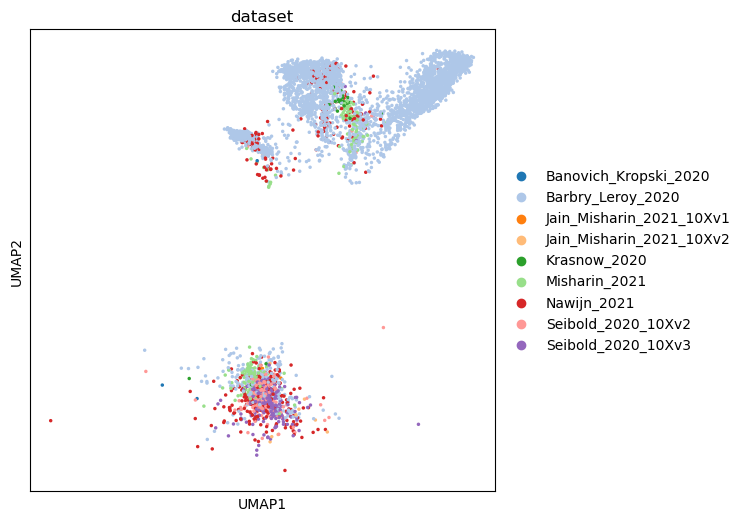

In [6]:
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(adata, color = "dataset", legend_fontsize = 10, size = 25, palette = sns.color_palette("tab20"))

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


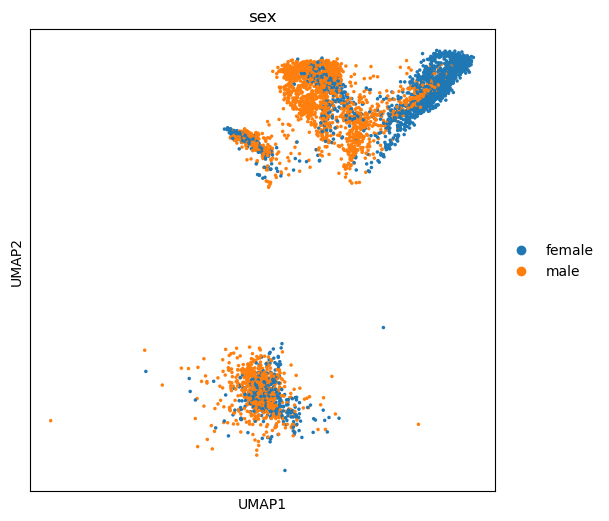

In [7]:
sc.pl.umap(adata, color = "sex")

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


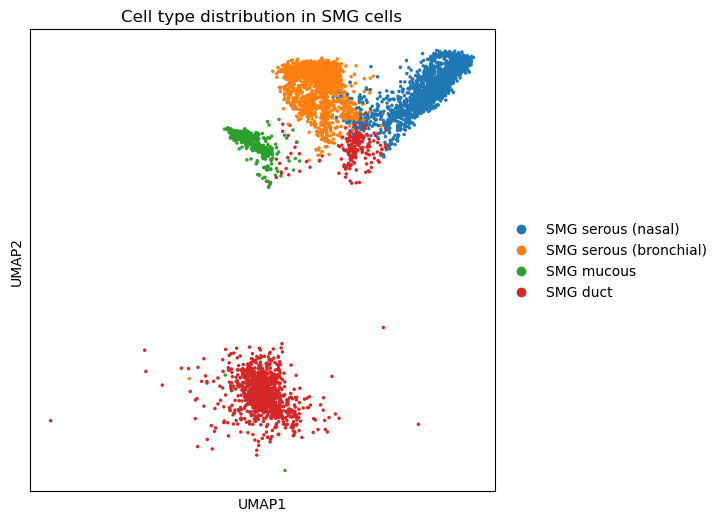

In [8]:
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(adata, color = "ann_finest_level", legend_fontsize = 10, size = 25, title = 'Cell type distribution in SMG cells')

**Zoom in on SMG serous subtype:**

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


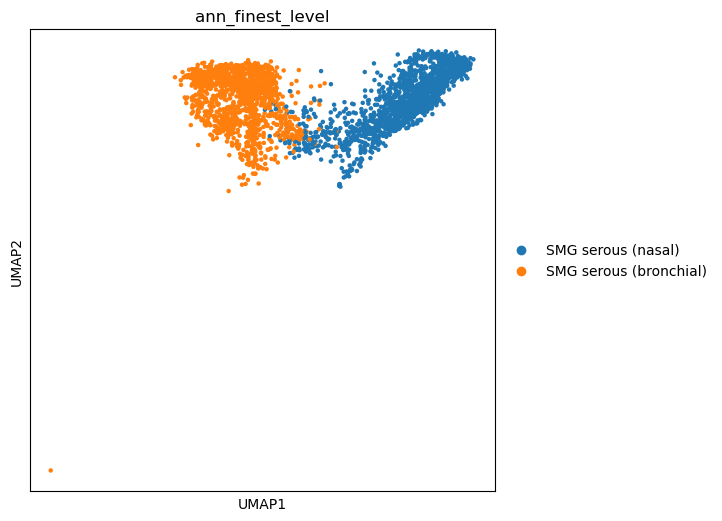

In [9]:
sc.pl.umap(adata[adata.obs["ann_level_4"] == 'SMG serous'], color = 'ann_finest_level')

Which datasets do SMG serous cells come from?

In [10]:
serous = adata[adata.obs["ann_level_4"] == 'SMG serous'].to_memory()
datasets = set(serous.obs["dataset"])
datasets

{'Barbry_Leroy_2020',
 'Krasnow_2020',
 'Misharin_2021',
 'Nawijn_2021',
 'Seibold_2020_10Xv2',
 'Seibold_2020_10Xv3'}

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


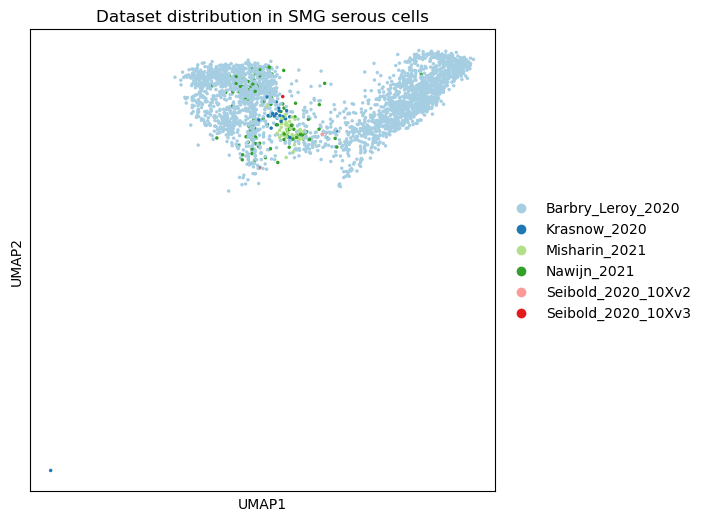

In [11]:
import random
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(serous, color = "dataset", legend_fontsize = 10, size = 25, title = 'Dataset distribution in SMG serous cells', palette = sns.color_palette("Paired"))

In [12]:
df = serous.obs
df = df.loc[:, ['sex','dataset']]
sex_distribution = df.groupby(['dataset', 'sex']).size().unstack(fill_value=0)
sex_distribution

sex,female,male
dataset,,
Barbry_Leroy_2020,1343,1343
Krasnow_2020,25,0
Misharin_2021,0,58
Nawijn_2021,37,79
Seibold_2020_10Xv2,0,1
Seibold_2020_10Xv3,2,1


In [13]:
sex_distribution_normalized = sex_distribution.div(sex_distribution.sum(axis=1), axis=0)
sex_distribution_normalized

sex,female,male
dataset,,
Barbry_Leroy_2020,0.500000,0.500000
Krasnow_2020,1.000000,0.000000
Misharin_2021,0.000000,1.000000
Nawijn_2021,0.318966,0.681034
Seibold_2020_10Xv2,0.000000,1.000000
Seibold_2020_10Xv3,0.666667,0.333333


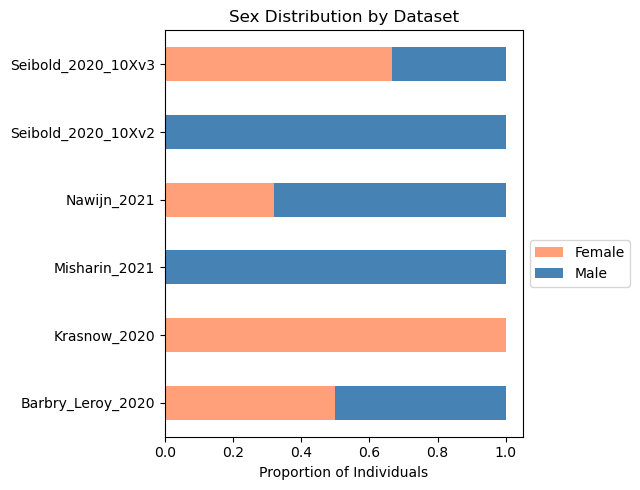

In [14]:
fig, ax = plt.subplots(figsize=(6.5, 5))
sex_distribution_normalized.plot(kind='barh', stacked=True, color={'female': 'lightsalmon', 'male': 'steelblue'}, ax=ax)
ax.set_xlabel('Proportion of Individuals')
ax.set_ylabel('')
ax.set_title('Sex Distribution by Dataset')
plt.legend(['Female', 'Male'], bbox_to_anchor=(1, 0.5))
plt.tight_layout()

SMG serous cells come mostly from Barbry_Leroy_2020, which is balanced in terms of sex.
How are individuals distributed within this dataset?

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


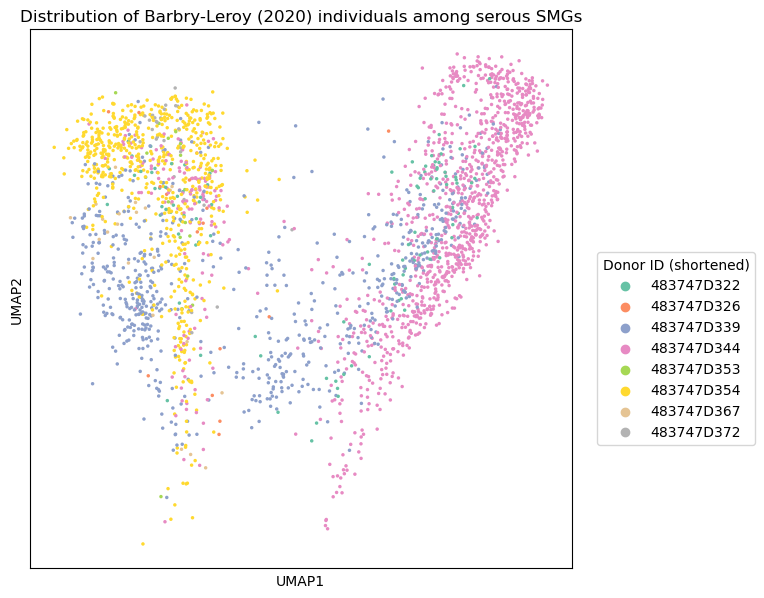

In [15]:
plt.rcParams["figure.figsize"] = [7,7]
# shorten donor id for plot legend
serous.obs['short_donor_id'] = serous.obs['donor_id'].apply(lambda x: x[-10:])
ax = sc.pl.umap(serous[serous.obs["dataset"] == 'Barbry_Leroy_2020'], 
                color=["short_donor_id"], 
                palette = sns.color_palette("Set2"),
                legend_loc="right margin", 
                legend_fontsize=10, 
                size=25,
                title = 'Distribution of Barbry-Leroy (2020) individuals among serous SMGs',
                return_fig = True)
plt.legend(title = 'Donor ID (shortened)', bbox_to_anchor=(1.35, 0.6))
plt.show()

In [16]:
set(serous[serous.obs["short_donor_id"] == '483747D344'].obs["sex"])

{'female'}

One (female) donor makes up most of the SMG serous (nasal) cluster.

## Batch correction using Harmony

### Batch effects from studies

In [17]:
adata = anndata.read_h5ad(path_data, backed = 'r')
adata = adata[adata.obs["ann_level_3"] == 'Submucosal Secretory'].to_memory()

In [18]:
sc.pp.pca(adata, n_comps = 30)
sc.external.pp.harmony_integrate(adata, 'dataset')

computing PCA
    with n_comps=30
    finished (0:00:07)


2024-06-22 13:14:35,893 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-22 13:14:39,498 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-22 13:14:39,603 - harmonypy - INFO - Iteration 1 of 10
2024-06-22 13:14:41,715 - harmonypy - INFO - Iteration 2 of 10
2024-06-22 13:14:43,822 - harmonypy - INFO - Iteration 3 of 10
2024-06-22 13:14:45,792 - harmonypy - INFO - Iteration 4 of 10
2024-06-22 13:14:47,744 - harmonypy - INFO - Iteration 5 of 10
2024-06-22 13:14:49,722 - harmonypy - INFO - Iteration 6 of 10
2024-06-22 13:14:51,845 - harmonypy - INFO - Iteration 7 of 10
2024-06-22 13:14:54,262 - harmonypy - INFO - Iteration 8 of 10
2024-06-22 13:14:56,321 - harmonypy - INFO - Iteration 9 of 10
2024-06-22 13:14:58,282 - harmonypy - INFO - Iteration 10 of 10
2024-06-22 13:15:00,258 - harmonypy - INFO - Stopped before convergence


In [19]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)


In [20]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


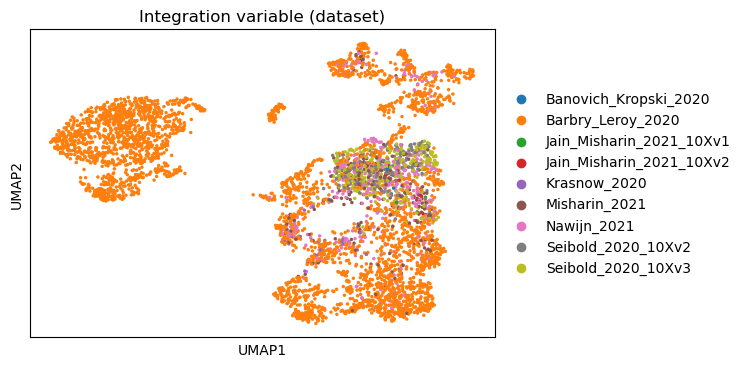

In [21]:
plt.rcParams["figure.figsize"] = [6,4]
sc.pl.umap(adata, color='dataset', legend_fontsize = 10, size = 25, title = 'Integration variable (dataset)')

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


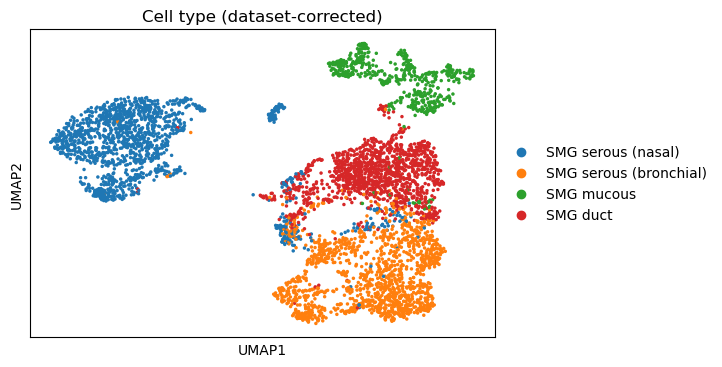

In [22]:
plt.rcParams["figure.figsize"] = [6,4]
sc.pl.umap(adata, color='ann_finest_level', legend_fontsize = 10, size = 25, title = 'Cell type (dataset-corrected)')

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


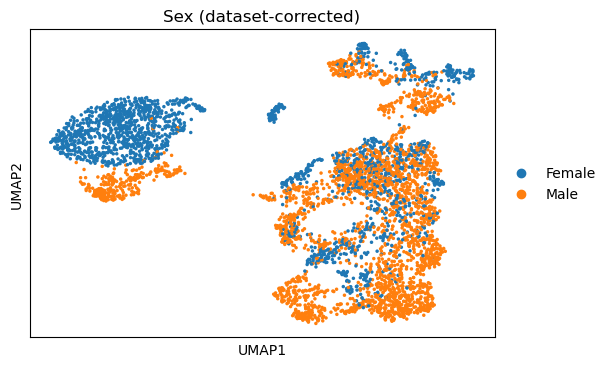

In [23]:
sex_color_map = {'male': 'steelblue', 'female': 'lightsalmon'}
# temp adata objects so we can modify the sex labels to uppercase
temp_obs = adata.obs.copy()
temp_obs['sex'] = temp_obs['sex'].replace({'female': 'Female', 'male': 'Male'})
temp_adata = adata.copy()
temp_adata.obs = temp_obs
sc.pl.umap(temp_adata, color='sex', legend_fontsize=10, size=25, title='Sex (dataset-corrected)')

Run this to save dataset-corrected data:

In [27]:
# adata.write('smg_dataset_corrected.h5ad')

### Batch effects from individuals

In [28]:
adata = anndata.read_h5ad(path_data, backed = 'r')
adata = adata[adata.obs["ann_level_3"] == 'Submucosal Secretory'].to_memory()

In [29]:
sc.pp.pca(adata, n_comps = 30)
sc.external.pp.harmony_integrate(adata, 'donor_id')

computing PCA
    with n_comps=30
    finished (0:00:07)


2024-06-22 13:17:01,820 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-22 13:17:05,399 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-22 13:17:05,495 - harmonypy - INFO - Iteration 1 of 10
2024-06-22 13:17:08,314 - harmonypy - INFO - Iteration 2 of 10
2024-06-22 13:17:11,150 - harmonypy - INFO - Iteration 3 of 10
2024-06-22 13:17:13,919 - harmonypy - INFO - Iteration 4 of 10
2024-06-22 13:17:16,698 - harmonypy - INFO - Iteration 5 of 10
2024-06-22 13:17:19,434 - harmonypy - INFO - Iteration 6 of 10
2024-06-22 13:17:22,201 - harmonypy - INFO - Iteration 7 of 10
2024-06-22 13:17:24,538 - harmonypy - INFO - Iteration 8 of 10
2024-06-22 13:17:25,964 - harmonypy - INFO - Iteration 9 of 10
2024-06-22 13:17:28,709 - harmonypy - INFO - Iteration 10 of 10
2024-06-22 13:17:31,392 - harmonypy - INFO - Stopped before convergence


In [30]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [31]:
combined_palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("Set1")
random.shuffle(combined_palette)

sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


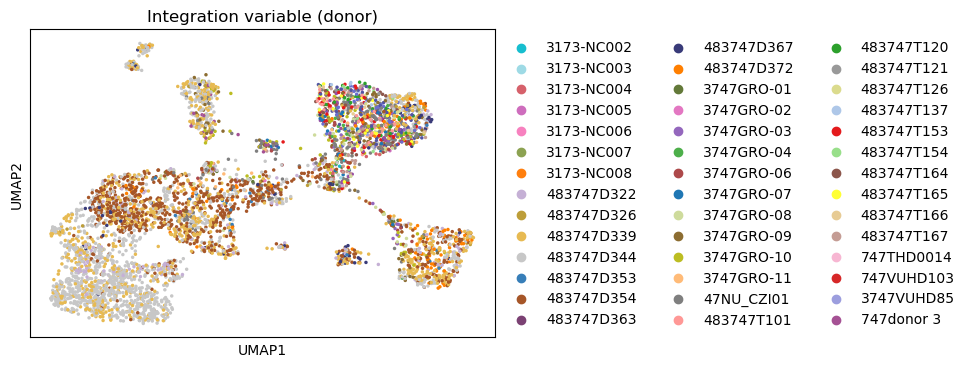

In [32]:
plt.rcParams["figure.figsize"] = [6,4]
adata.obs['short_donor_id'] = adata.obs['donor_id'].apply(lambda x: x[-10:])
sc.pl.umap(adata, color='short_donor_id', palette = combined_palette, legend_fontsize = 10, size = 25, title = 'Integration variable (donor)')

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


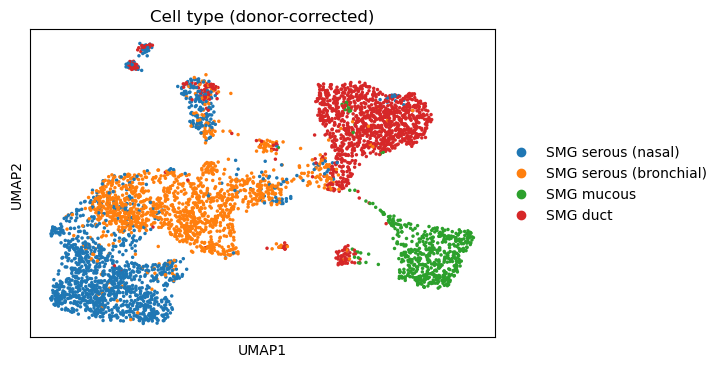

In [33]:
plt.rcParams["figure.figsize"] = [6,4]
sc.pl.umap(adata, color='ann_finest_level', legend_fontsize = 10, size = 25, title = 'Cell type (donor-corrected)')

C:\Users\SG\Documents\anaconda\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


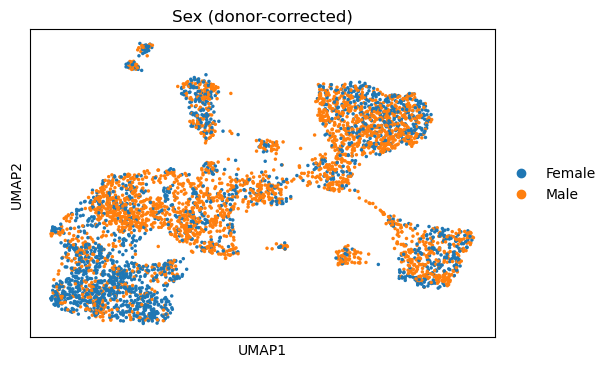

In [34]:
sex_color_map = {'male': 'steelblue', 'female': 'lightsalmon'}
# temp adata objects so we can modify the sex labels to uppercase
temp_obs = adata.obs.copy()
temp_obs['sex'] = temp_obs['sex'].replace({'female': 'Female', 'male': 'Male'})
temp_adata = adata.copy()
temp_adata.obs = temp_obs
sc.pl.umap(temp_adata, color='sex', legend_fontsize=10, size=25, title='Sex (donor-corrected)')

Run this to save donor-corrected data:

In [37]:
# adata.write('smg_donor_corrected.h5ad')